In [8]:
import os
import random
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


# ─── Reproducibility ───────────────────────────────────────────────────────
RANDOM_STATE = 42
os.environ['PYTHONHASHSEED']      = str(RANDOM_STATE)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


# ─── Configuration ─────────────────────────────────────────────────────────
SCORE_PATH    = 'data/dataset_for_scoring.csv'
SEQUENCE_PATH = 'data/all_kinect_trimmed'
TEST_SIZE     = 0.1

FRAMES      = 48    # fixed frames per sequence
EPOCHS      = 500
ES_PATIENCE = 20    # early-stopping
CV_SPLITS   = 5

param_grid = {
    'conv_filters':  [16],
    'conv_kernel':   [3],
    'pool_size':     [1],
    'lstm_units':    [16],
    'dropout_rate':  [0.0],
    'dense_units':   [[64, 32]],
    'learning_rate': [1e-3],
    'batch_size':    [32],
}


# ─── Data Loading & Preprocessing ──────────────────────────────────────────
def load_data(score_path, seq_path):
    """
    Load scoring CSV, drop 'A1', scale Var2 to [0,4], and
    load each Kinect CSV into a list of numpy arrays.
    """
    print(">> Loading data…")
    df = pd.read_csv(score_path)
    df = df[df['filename'] != 'A1']  # drop outlier
    scores = df['Var2'].to_numpy().reshape(-1, 1)
    scaler_y = MinMaxScaler(feature_range=(0, 4))
    y = scaler_y.fit_transform(scores).ravel()
    # Save the target scaler so you can use it for ground truth and inference
    with open('models/score_minmaxscaler.pkl', 'wb') as f:
        pickle.dump(scaler_y, f)

    X = []
    for fname in df['filename']:
        path = os.path.join(seq_path, f"{fname}_kinect.csv")
        seq = pd.read_csv(path).drop(columns='FrameNo').to_numpy()
        X.append(seq)
    print(f"   Loaded {len(X)} sequences, targets scaled to [0,4].\n")
    return X, y


def sample_sequence(seq, n_frames=FRAMES):
    """
    Uniformly sample or pad `seq` to exactly `n_frames`.
    If longer, picks evenly spaced frames; if shorter, pads with zeros.
    """
    T, D = seq.shape
    if T >= n_frames:
        idx = np.linspace(0, T - 1, n_frames).round().astype(int)
        return seq[idx]
    pad = np.zeros((n_frames - T, D), dtype=seq.dtype)
    return np.vstack([seq, pad])


def preprocess_and_scale(X, scaler=None):
    """
    Sample/pad each sequence in X to FRAMES, stack them,
    then fit/transform with StandardScaler if needed.
    Returns (X_scaled, scaler).
    """
    arr = np.stack([sample_sequence(s) for s in X], axis=0)
    flat = arr.reshape(-1, arr.shape[-1])
    if scaler is None:
        scaler = StandardScaler().fit(flat)
    scaled = scaler.transform(flat).reshape(arr.shape)
    return scaled, scaler


# ─── Model & Cross-Validation ──────────────────────────────────────────────
def build_model(n_features, params):
    """
    Build & compile a CNN→Pooling→LSTM→(optional Dense head)→Dense regressor.
    """
    K.clear_session()
    m = Sequential([
        Input(shape=(FRAMES, n_features)),
        Conv1D(params['conv_filters'], params['conv_kernel'],
               padding='same', activation='relu'),
        Dropout(params['dropout_rate']),
        MaxPooling1D(pool_size=params['pool_size']),
        LSTM(params['lstm_units'],
             dropout=params['dropout_rate'],
             recurrent_dropout=params['dropout_rate']),
        Dropout(params['dropout_rate']),
    ])
    for h in params.get('dense_units', []):
        m.add(Dense(h, activation='relu'))
        m.add(Dropout(params['dropout_rate']))
    m.add(Dense(1, activation='linear'))
    m.compile(
        optimizer=Adam(learning_rate=params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return m


def evaluate_params(X, y, params, n_splits=CV_SPLITS):
    """
    Perform K-fold cross-validation for one hyperparameter set.
    Returns arrays of fold MSEs and MAEs.
    """
    mses, maes = [], []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    for train_idx, val_idx in kf.split(X):
        X_tr, _  = preprocess_and_scale([X[i] for i in train_idx])
        X_val, _ = preprocess_and_scale([X[i] for i in val_idx], scaler=_)
        y_tr, y_val = y[train_idx], y[val_idx]

        model = build_model(X_tr.shape[-1], params)
        es = EarlyStopping(monitor='val_loss', patience=ES_PATIENCE,
                           restore_best_weights=True)

        model.fit(
            X_tr, y_tr,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=params['batch_size'],
            callbacks=[es],
            verbose=0
        )
        mse, mae = model.evaluate(X_val, y_val, verbose=0)
        mses.append(mse)
        maes.append(mae)

    return np.array(mses), np.array(maes)


def grid_search_cv(X_train, y_train, param_grid):
    """
    Loop over param_grid, run CV, print progress,
    and at the end report best params with CV stats.
    """
    print(">> Starting grid search…")
    combos = list(ParameterGrid(param_grid))
    best_score = np.inf
    best_params = None
    best_stats = {}

    for i, params in enumerate(combos, start=1):
        rem = len(combos) - i
        print(f"  [{i}/{len(combos)}] {params} — {rem} left")
        mses, maes = evaluate_params(X_train, y_train, params)
        m_mae, s_mae = maes.mean(), maes.std()
        print(f"     mean val MAE = {m_mae:.4f} ± {s_mae:.4f}")

        if m_mae < best_score:
            best_score  = m_mae
            best_params = params
            best_stats = {
                'mse': (mses.mean(), maes.std()),
                'mae': (m_mae,     s_mae)
            }

    mse_m, _ = best_stats['mse']
    mae_m, mae_s = best_stats['mae']
    print("\n*** Grid search complete ***")
    print(f"→ Best params: {best_params}")
    print(f"→ CV MSE: {mse_m:.4f}")
    print(f"→ CV MAE: {mae_m:.4f} ± {mae_s:.4f}\n")
    return best_params


# ─── Metrics & Plotting ────────────────────────────────────────────────────
def compute_metrics(y_true, y_pred):
    """
    Compute (MSE, MAE, Pearson r) between two arrays.
    """
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    return mse, mae, r


def plot_pred_vs_true(ax, y_true, y_pred, title=None):
    """
    On `ax`, scatter y_true vs y_pred with identity line in [0,5].
    """
    ax.scatter(y_true, y_pred, alpha=0.6)
    ax.plot([0, 5], [0, 5], 'k--', label='Ideal')
    ax.set_xlim(0, 5); ax.set_ylim(0, 5)
    ax.set_xlabel("True"); ax.set_ylabel("Pred")
    if title: ax.set_title(title)
    ax.legend()


def bland_altman_plot(ax, y_true, y_pred, title=None):
    """
    On `ax`, draw Bland–Altman: mean on x (0–5), diff on y (−1.5–1.5),
    with zero line, mean line, and 95% CI.
    """
    diff = y_pred - y_true
    mn   = (y_pred + y_true) / 2
    md   = diff.mean()
    sd   = diff.std(ddof=1)

    ax.scatter(mn, diff, alpha=0.6)
    ax.axhline(0, color='black', linewidth=1)
    ax.axhline(md, color='blue', linewidth=1, label=f'Mean ({md:.2f})')
    up, lo = md + 1.96*sd, md - 1.96*sd
    ax.axhline(up, color='blue', linestyle='--', label='95% CI')
    ax.axhline(lo, color='blue', linestyle='--')
    ax.set_xlim(0, 5); ax.set_ylim(-1.5, 1.5)
    ax.set_xlabel("Mean (True+Pred)/2"); ax.set_ylabel("Pred − True")
    if title: ax.set_title(title)
    ax.legend()


def plot_training_history(history):
    """
    Plot side-by-side training vs validation MSE and MAE from history.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['loss'],     label='Train MSE')
    ax[0].plot(history.history['val_loss'], label='Val   MSE')
    ax[0].set_title('MSE'); ax[0].set_xlabel('Epoch'); ax[0].legend()
    ax[1].plot(history.history['mae'],      label='Train MAE')
    ax[1].plot(history.history['val_mae'],  label='Val   MAE')
    ax[1].set_title('MAE'); ax[1].set_xlabel('Epoch'); ax[1].legend()
    plt.tight_layout(); plt.show()


def evaluate_and_plot(y_tr, y_pred_tr, y_te, y_pred_te):
    """
    1) True vs Pred side-by-side
    2) Bland–Altman side-by-side
    3) Print Train/Test metrics to console
    """
    # True vs Pred
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    plot_pred_vs_true(ax[0], y_tr,    y_pred_tr, title="True vs Pred (Train)")
    plot_pred_vs_true(ax[1], y_te,    y_pred_te, title="True vs Pred (Test)")
    plt.tight_layout(); plt.show()

    # Bland–Altman
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    bland_altman_plot(ax[0], y_tr,    y_pred_tr, title="Bland-Altman (Train)")
    bland_altman_plot(ax[1], y_te,    y_pred_te, title="Bland-Altman (Test)")
    plt.tight_layout(); plt.show()

    # Print metrics
    tr_mse, tr_mae, tr_r = compute_metrics(y_tr, y_pred_tr)
    te_mse, te_mae, te_r = compute_metrics(y_te, y_pred_te)
    print(f"\n=== Results ===")
    print(f"{'':<8}{'MSE':>8}{'MAE':>8}{'   r':>8}")
    print(f"{'Train':<8}{tr_mse:8.4f}{tr_mae:8.4f}{tr_r:8.4f}")
    print(f"{'Test':<8}{te_mse:8.4f}{te_mae:8.4f}{te_r:8.4f}\n")


# ─── Final Training & Saving ──────────────────────────────────────────────
def train_final_model(X_train, y_train, best_params):
    """
    Train on full development set and return (model, scaler, history).
    """
    print(">> Training final model…")
    X_tr, scaler = preprocess_and_scale(X_train)
    model = build_model(X_tr.shape[-1], best_params)

    es = EarlyStopping(monitor='val_loss',
                       patience=ES_PATIENCE,
                       restore_best_weights=True)

    history = model.fit(
        X_tr, y_train,
        validation_split=0.1,
        epochs=EPOCHS,
        batch_size=best_params['batch_size'],
        callbacks=[es],
        verbose=0
    )
    return model, scaler, history


def final_evaluate(model, scaler, history,
                   X_train, y_train, X_test, y_test, best_params):
    """
    Perform final evaluation: plot history, preprocess,
    predict, and call evaluate_and_plot.
    """
    print(">> Evaluating final model…")
    model.summary()
    plot_training_history(history)

    X_tr, _ = preprocess_and_scale(X_train, scaler=scaler)
    X_te, _ = preprocess_and_scale(X_test,  scaler=scaler)

    y_pred_tr = model.predict(X_tr,
                              batch_size=best_params['batch_size'],
                              verbose=0)[:, 0]
    y_pred_te = model.predict(X_te,
                              batch_size=best_params['batch_size'],
                              verbose=0)[:, 0]

    evaluate_and_plot(y_train, y_pred_tr, y_test, y_pred_te)


def save_model_and_scaler(model, scaler,
                          model_path='models/scorer_model.keras',
                          scaler_path='models/scorer_scaler.pkl'):
    """
    Save Keras model (.keras format) and scaler (.pkl),
    and print confirmation.
    """
    model.save(model_path)
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)

    print("=== Artifacts Saved ===")
    print(f"✅ Model : {model_path}")
    print(f"✅ Scaler: {scaler_path}\n")


# ─── Scoring ──────────────────────────────────────────────

def predict_squat_score(csv_path,
                        model_path='models/scorer_model.keras',
                        scaler_path='models/scorer_scaler.pkl'):
    """
    Load the trained Keras model and scaler from disk, then:
      1. Read csv_path (drop FrameNo)
      2. Uniformly sample/pad to FRAMES frames
      3. Frame‐wise StandardScaler transform
      4. Predict with the model → float score
    """
    # 0) load artifacts
    model = tf.keras.models.load_model(model_path)
    with open(scaler_path, 'rb') as f:
        scaler = pickle.load(f)

    # 1) read & drop
    seq = pd.read_csv(csv_path).drop(columns='FrameNo').to_numpy()

    # 2) sample / pad
    sampled = sample_sequence(seq)            # assumes sample_sequence is in scope

    # 3) scale each frame
    scaled = scaler.transform(sampled)        # (FRAMES, D)

    # 4) add batch dim and predict
    x = np.expand_dims(scaled, axis=0)        # (1, FRAMES, D)
    y_pred = model.predict(x, verbose=0)[0,0]

    return float(y_pred)


def get_actual_score(csv_path, score_csv_path='data/dataset_for_scoring.csv'):
    """
    Given a Kinect CSV filepath, look up its ground-truth Var2 score
    (dropping the 'A1' outlier), scale it into [0,4] exactly as in training,
    and return it as a float.

    Parameters
    ----------
    csv_path : str
        Path to the `<filename>_kinect.csv` you want the true score for.
    score_csv_path : str
        Path to your `dataset_for_scoring.csv` (with columns 'filename' & 'Var2').

    Returns
    -------
    float
        The scaled ground-truth score in [0,4].
    """
    # 1) load scoring table
    df = pd.read_csv(score_csv_path)
    df = df[df['filename'] != 'A1']  # drop the A1 outlier

    # 2) figure out base filename (without "_kinect.csv")
    base = os.path.basename(csv_path)
    if base.endswith('_kinect.csv'):
        fname = base[:-len('_kinect.csv')]
    else:
        fname = os.path.splitext(base)[0]

    # 3) find that row
    row = df[df['filename'] == fname]
    if row.empty:
        raise ValueError(f"No ground-truth entry for '{fname}' in {score_csv_path}")

    # 4) use the saved MinMaxScaler to transform the score
    with open('models/score_minmaxscaler.pkl', 'rb') as f:
        scaler_y = pickle.load(f)
    true_score = scaler_y.transform([[row['Var2'].iloc[0]]])[0, 0]


    return float(true_score)

In [9]:
# Load & split
X_all, y_all = load_data(SCORE_PATH, SEQUENCE_PATH)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

>> Loading data…
   Loaded 105 sequences, targets scaled to [0,4].



In [10]:
# Grid search
best_params = grid_search_cv(X_train, y_train, param_grid)

>> Starting grid search…
  [1/1] {'batch_size': 32, 'conv_filters': 16, 'conv_kernel': 3, 'dense_units': [64, 32], 'dropout_rate': 0.0, 'learning_rate': 0.001, 'lstm_units': 16, 'pool_size': 1} — 0 left
     mean val MAE = 0.4196 ± 0.0231

*** Grid search complete ***
→ Best params: {'batch_size': 32, 'conv_filters': 16, 'conv_kernel': 3, 'dense_units': [64, 32], 'dropout_rate': 0.0, 'learning_rate': 0.001, 'lstm_units': 16, 'pool_size': 1}
→ CV MSE: 0.2716
→ CV MAE: 0.4196 ± 0.0231



In [11]:
# Train
model, scaler, history = train_final_model(X_train, y_train, best_params)

>> Training final model…


>> Evaluating final model…


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 16)         │         1,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,605 (84.40 KB)

 Trainable params: 7,201 (28.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,404 (56.27 KB)

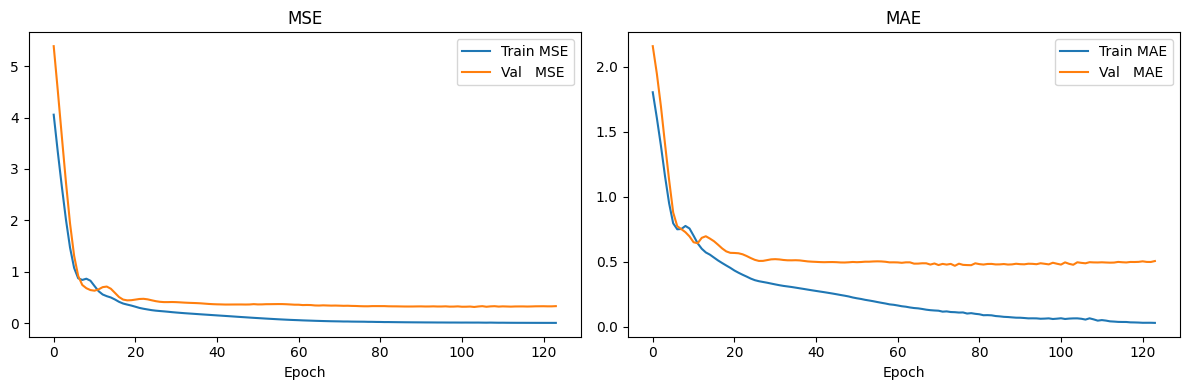

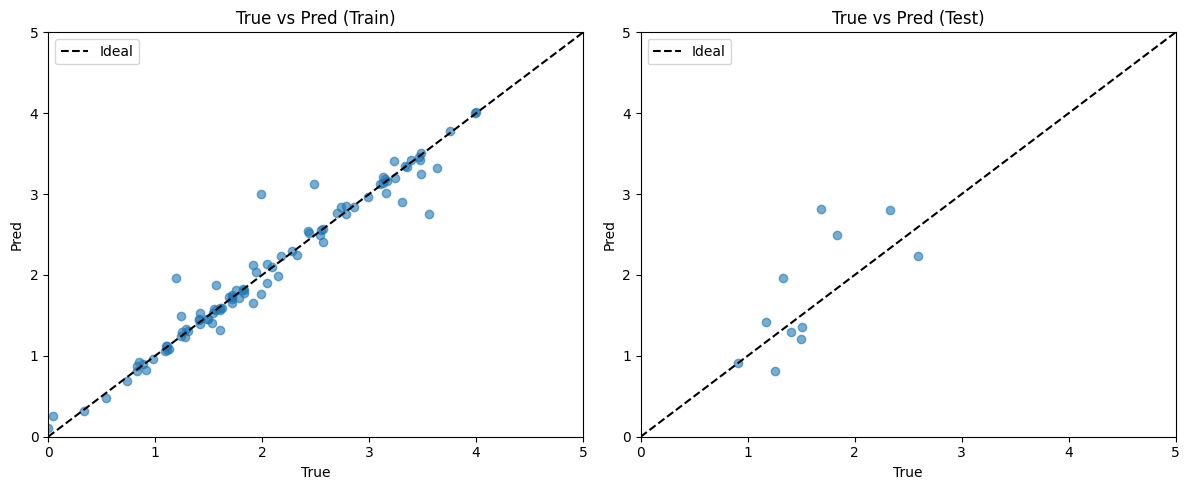

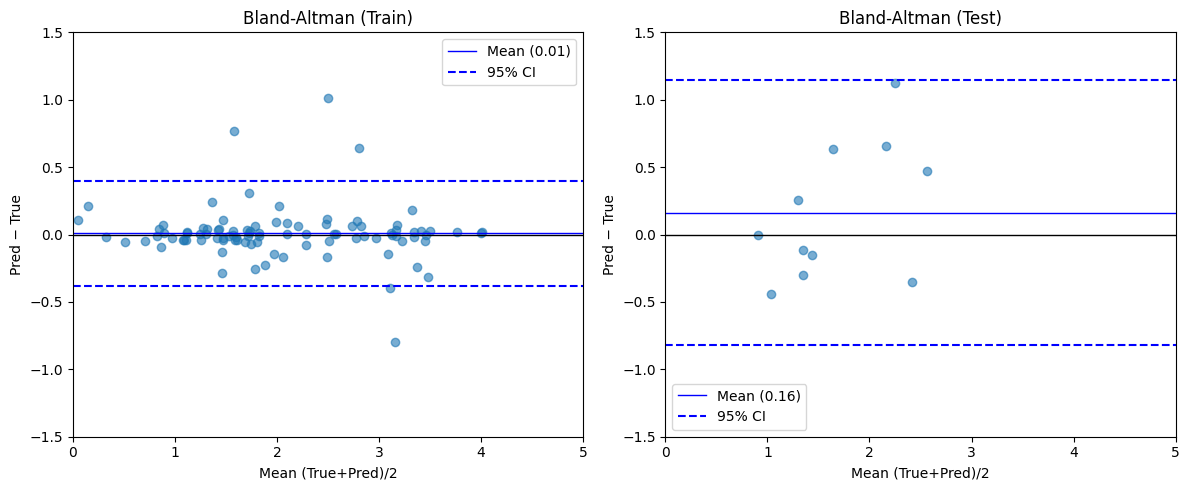


=== Results ===
             MSE     MAE       r
Train     0.0396  0.1024  0.9773
Test      0.2559  0.4081  0.7330



In [12]:
# Evaluate
final_evaluate(
    model, scaler, history,
    X_train, y_train,
    X_test,  y_test,
    best_params
)

In [13]:
# Save
save_model_and_scaler(model, scaler)

=== Artifacts Saved ===
✅ Model : models/scorer_model.keras
✅ Scaler: models/scorer_scaler.pkl



In [14]:
csv_file = 'data/all_kinect_trimmed/A23_kinect.csv'

# predicted:
pred = predict_squat_score(csv_file)
print("Predicted:", pred)

# actual:
actual = get_actual_score(csv_file)
print("Ground truth:", actual)

Predicted: 1.3190698623657227
Ground truth: 1.6016054194093332
